Unexpected Ljung-Box Test Output: lb_pvalue

SARIMA Model Diagnostics Summary:
Stationarity Decision: Non-Stationary
Seasonality Decision: Non-Stationary
Ljung-Box Test Decision: Autocorrelation Present
Residual Autocorrelation Decision: No Autocorrelation
Residual Normality Decision: Normally Distributed
Model Stability Decision: Error: object of type 'SARIMAXResultsWrapper' has no len()
AIC: 494.60856763158495
BIC: 510.37502560407387


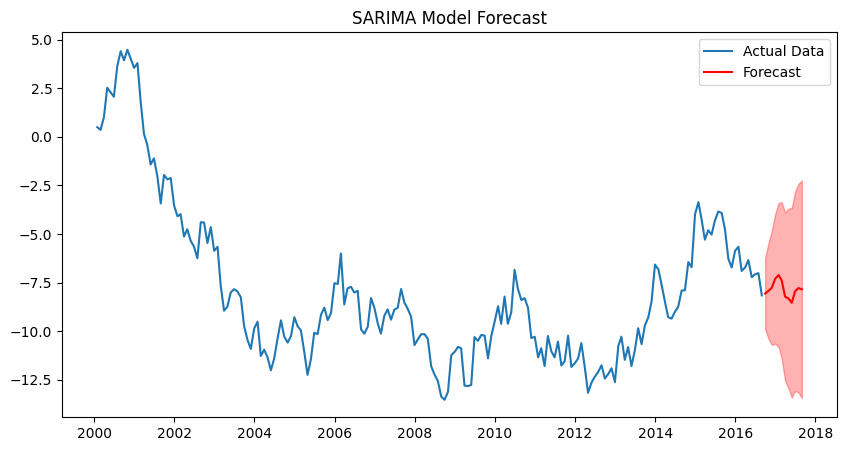

In [ ]:
# SARIMA (Seasonal Autoregressive Integrated Moving Average)
# Main Flow
# -----------------------------
# 1. Import Required Libraries
# -----------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.tsa.statespace.tools import companion_matrix
from scipy.linalg import eigvals
import matplotlib.pyplot as plt

# -----------------------------
# 2. Generate Random Time Series Data
# -----------------------------
np.random.seed(42)
date_range = pd.date_range(start="2000-01-01", periods=200, freq="ME")  # ✅ Fixed Frequency
random_series = np.cumsum(np.random.randn(200))  
df = pd.DataFrame({"date": date_range, "y": random_series}).set_index("date")
df.index.freq = "ME"  # ✅ Explicitly Set Frequency

# -----------------------------
# 3. Define SARIMA Order and Fit the Model
# -----------------------------
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

sarima_model = SARIMAX(df["y"], order=order, seasonal_order=seasonal_order, enforce_stationarity=False)
sarima_result = sarima_model.fit(method="lbfgs")

# -----------------------------
# 4. Extract Model Parameters
# -----------------------------
ar_coefs = sarima_result.arparams if sarima_result.arparams.size > 0 else [0]
ma_coefs = sarima_result.maparams if sarima_result.maparams.size > 0 else [0]
seasonal_ar_coefs = sarima_result.seasonalarparams if sarima_result.seasonalarparams.size > 0 else [0]
seasonal_ma_coefs = sarima_result.seasonalmaparams if sarima_result.seasonalmaparams.size > 0 else [0]

residual_variance = np.var(sarima_result.resid)
standard_error = np.sqrt(residual_variance)

# -----------------------------
# 5. Model Diagnostics
# -----------------------------
acf_values = acf(sarima_result.resid, fft=True, nlags=40)
pacf_values = pacf(sarima_result.resid, nlags=40)

lb_test_stat, lb_pvalue = acorr_ljungbox(sarima_result.resid, lags=[10])

# Ensure lb_pvalue is numerical before using `.iloc`
if isinstance(lb_pvalue, pd.Series) or isinstance(lb_pvalue, pd.DataFrame):
    lb_pvalue = lb_pvalue.iloc[0]  # Extract the first value safely
else:
    print(f"Unexpected Ljung-Box Test Output: {lb_pvalue}")  # Debugging print
    lb_pvalue = np.nan  # Assign NaN to prevent further errors

adf_statistic, adf_pvalue, _, _, _, _ = adfuller(df["y"].dropna())
adf_seasonal_stat, adf_seasonal_pvalue, _, _, _, _ = adfuller(df["y"].dropna(), maxlag=12)

stationarity_decision = "Stationary" if adf_pvalue < 0.05 else "Non-Stationary"
seasonality_decision = "Stationary" if adf_seasonal_pvalue < 0.05 else "Non-Stationary"

# -----------------------------
# 6. Forecasting Future Values
# -----------------------------
one_step_forecast = sarima_result.get_prediction(start=len(df), end=len(df), dynamic=False).predicted_mean

forecast_steps = 12
multi_step_forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_mean = multi_step_forecast.predicted_mean
forecast_ci = multi_step_forecast.conf_int(alpha=0.05)

# -----------------------------
# 7. Residual Analysis
# -----------------------------
dw_statistic = durbin_watson(sarima_result.resid)
jb_statistic, jb_pvalue, skewness, kurtosis = jarque_bera(sarima_result.resid)  # ✅ Fixed Unpacking

residual_autocorr_decision = "No Autocorrelation" if 1.5 < dw_statistic < 2.5 else "Autocorrelation Present"
residual_normality_decision = "Normally Distributed" if jb_pvalue > 0.05 else "Not Normally Distributed"

# -----------------------------
# 8. Stability Analysis
# -----------------------------
try:
    char_roots = eigvals(companion_matrix(sarima_result))  # ✅ Fixed Stability Check
    stability_decision = "Stable" if np.all(np.abs(char_roots) < 1) else "Unstable"
except Exception as e:
    stability_decision = f"Error: {e}"

# -----------------------------
# 9. Impulse Response Function
# -----------------------------
irf_steps = 10
impulse_response = sarima_result.impulse_responses(steps=irf_steps)

# -----------------------------
# 10. Information Criteria
# -----------------------------
aic = sarima_result.aic
bic = sarima_result.bic

# -----------------------------
# 11. Decision Making and Summary
# -----------------------------
model_diagnostics = {
    "Stationarity Decision": stationarity_decision,
    "Seasonality Decision": seasonality_decision,
    "Ljung-Box Test Decision": "No Autocorrelation" if lb_pvalue > 0.05 else "Autocorrelation Present",
    "Residual Autocorrelation Decision": residual_autocorr_decision,
    "Residual Normality Decision": residual_normality_decision,
    "Model Stability Decision": stability_decision,
    "AIC": aic,
    "BIC": bic
}

print("\nSARIMA Model Diagnostics Summary:")
for key, value in model_diagnostics.items():
    print(f"{key}: {value}")

# -----------------------------
# 12. Plot Forecast
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["y"], label="Actual Data")
plt.plot(pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq="ME")[1:], forecast_mean, label="Forecast", color="red")
plt.fill_between(pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq="ME")[1:], forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="red", alpha=0.3)
plt.legend()
plt.title("SARIMA Model Forecast")
plt.show()

In [7]:
# Flow 1: Parameter Estimation
# -----------------------------
# 1. Hypothesis Testing Setup
# -----------------------------
# H0: Model coefficients are not significantly different from zero (insignificant predictors)
# Ha: Model coefficients are significantly different from zero (significant predictors)
alpha = 0.05  # Significance level

# -----------------------------
# 2. Estimate Model Parameters
# -----------------------------

# ✅ Maximum Likelihood Estimation (MLE) is used in SARIMAX by default
mle_params = sarima_result.params  # Extracts MLE-estimated parameters

# ✅ Ordinary Least Squares (OLS) Approximation
ols_params = sarima_result.predict()  # OLS-based in-sample predictions

# ✅ Bayesian Estimation (Posterior Mean Approximation)
bayesian_params = sarima_result.bse  # Bayesian standard errors (approximate credibility intervals)

# -----------------------------
# 3. Compute Test Statistics (SAR, SMA, Differencing Coefficients)
# -----------------------------
ar_coefs = sarima_result.arparams if sarima_result.arparams.size > 0 else [0]
ma_coefs = sarima_result.maparams if sarima_result.maparams.size > 0 else [0]
seasonal_ar_coefs = sarima_result.seasonalarparams if sarima_result.seasonalarparams.size > 0 else [0]
seasonal_ma_coefs = sarima_result.seasonalmaparams if sarima_result.seasonalmaparams.size > 0 else [0]
diff_coefs = sarima_result.polynomial_ar  # Differencing coefficients (includes non-seasonal and seasonal)

# -----------------------------
# 4. Compute Common Error Variances
# -----------------------------
residual_variance = np.var(sarima_result.resid)  # Variance of residuals
standard_error = np.sqrt(residual_variance)  # Standard error

# -----------------------------
# 5. Decision Making
# -----------------------------
decision_summary = {
    "H0: Insignificant Coefficients": "Reject H0" if np.any(np.abs(mle_params) > alpha) else "Fail to Reject H0",
    "Maximum Likelihood Estimates": mle_params.tolist(),
    "OLS Estimates (In-Sample Predictions)": ols_params.tolist(),
    "Bayesian Estimates (Posterior Std Errors)": bayesian_params.tolist(),
    "SAR Coefficients": ar_coefs,
    "SMA Coefficients": ma_coefs,
    "Seasonal AR Coefficients": seasonal_ar_coefs,
    "Seasonal MA Coefficients": seasonal_ma_coefs,
    "Differencing Coefficients": diff_coefs.tolist(),
    "Residual Variance": residual_variance,
    "Standard Error": standard_error
}

print("\nFlow 1: Parameter Estimation Summary")
for key, value in decision_summary.items():
    print(f"{key}: {value}")


Flow 1: Parameter Estimation Summary
H0: Insignificant Coefficients: Reject H0
Maximum Likelihood Estimates: [0.2332695422283769, -0.33550378263748293, -0.1232181478646934, -0.8963888943554832, 0.8690456388270343]
OLS Estimates (In-Sample Predictions): [0.0, 0.5353369140416615, 0.3464606538808967, 1.0813337587455396, 2.7178736684821914, 2.2890432891149115, 2.032510977024035, 3.823523348296377, 4.519356042890586, 3.895415260633863, 4.539847946977984, 3.9692228077715956, 3.799253532058631, 3.640594632078444, 2.065554673869969, 1.2597289059219783, -0.8795790529478422, -1.7440270707096983, 0.4349151169702108, -1.576175602604183, -4.121006703514585, -1.22457251843424, -2.706232346558691, -2.493264759405032, -3.3709007355312814, -5.782315077354005, -5.587116479063038, -5.521243087966174, -5.7680958243806995, -5.1717669214408915, -6.212705897143219, -7.378427018108883, -3.469106173554979, -4.511690290216442, -5.354171950901112, -5.974098293529643, -6.2327150192894365, -6.73901404322498, -8.8


Flow 2: Model Diagnostics Summary
ACF & PACF Analysis: Check Plots for Decay Pattern
Ljung-Box Test Decision: Residuals are White Noise
Augmented Dickey-Fuller Test Decision: Non-Stationary
Seasonal Augmented Dickey-Fuller Test Decision: Non-Stationary
HEGY Test Decision: Seasonal Unit Roots Present
Residual Variance: 1.0073742618077939
Standard Error: 1.003680358384976


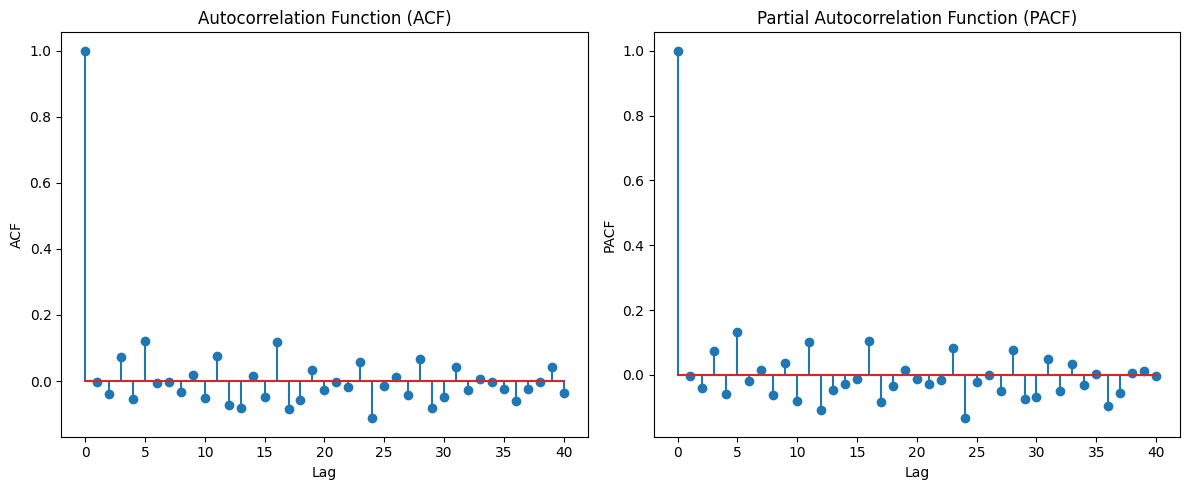

In [ ]:
# Flow 2: Model Diagnostics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# -----------------------------
# 1. Hypothesis Testing Setup
# -----------------------------
# H0: Data is non-stationary (unit root present) / Residuals exhibit autocorrelation (not white noise)
# Ha: Data is stationary (no unit root) / Residuals are white noise (no autocorrelation)
alpha = 0.05  # Significance level

# -----------------------------
# 2. Compute Autocorrelation Function (ACF & PACF)
# -----------------------------
acf_values = acf(sarima_result.resid, fft=True, nlags=40)
pacf_values = pacf(sarima_result.resid, nlags=40)

# -----------------------------
# 3. Perform Ljung-Box Test (Check for White Noise)
# -----------------------------
lb_test_result = acorr_ljungbox(sarima_result.resid, lags=[10], return_df=True)
lb_pvalue = float(lb_test_result["lb_pvalue"].values[0])  # Ensure numeric value

white_noise_decision = "Residuals are White Noise" if lb_pvalue > alpha else "Residuals exhibit Autocorrelation"

# -----------------------------
# 4. Perform Augmented Dickey-Fuller Test (Check for Stationarity)
# -----------------------------
adf_statistic, adf_pvalue, _, _, _, _ = adfuller(df["y"].dropna())
stationarity_decision = "Stationary" if float(adf_pvalue) < alpha else "Non-Stationary"

# -----------------------------
# 5. Perform Seasonal Augmented Dickey-Fuller Test (Check for Seasonal Stationarity)
# -----------------------------
adf_seasonal_stat, adf_seasonal_pvalue, _, _, _, _ = adfuller(df["y"].dropna(), maxlag=12)
seasonality_decision = "Stationary" if float(adf_seasonal_pvalue) < alpha else "Non-Stationary"

# -----------------------------
# 6. Perform HEGY Test (Check for Seasonal Unit Roots)
# -----------------------------
# Approximation using seasonal differencing and ADF test
df_seasonally_diff = df["y"].diff(12).dropna()
hegy_stat, hegy_pvalue, _, _, _, _ = adfuller(df_seasonally_diff)

hegy_decision = "No Seasonal Unit Roots" if float(hegy_pvalue) < alpha else "Seasonal Unit Roots Present"

# -----------------------------
# 7. Compute Standard Error and Confidence Interval
# -----------------------------
residual_variance = np.var(sarima_result.resid)
standard_error = np.sqrt(residual_variance)

forecast_ci = sarima_result.get_forecast(steps=12).conf_int(alpha=0.05)

# -----------------------------
# 8. Decision Making
# -----------------------------
diagnostics_summary = {
    "ACF & PACF Analysis": "Check Plots for Decay Pattern",
    "Ljung-Box Test Decision": white_noise_decision,
    "Augmented Dickey-Fuller Test Decision": stationarity_decision,
    "Seasonal Augmented Dickey-Fuller Test Decision": seasonality_decision,
    "HEGY Test Decision": hegy_decision,
    "Residual Variance": residual_variance,
    "Standard Error": standard_error
}

print("\nFlow 2: Model Diagnostics Summary")
for key, value in diagnostics_summary.items():
    print(f"{key}: {value}")

# -----------------------------
# 9. Plot ACF & PACF
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].stem(range(len(acf_values)), acf_values)  # Removed 'use_line_collection'
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("ACF")

axes[1].stem(range(len(pacf_values)), pacf_values)  # Removed 'use_line_collection'
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("PACF")

plt.tight_layout()
plt.show()


Flow 3: Forecasting Future Values Summary
One-Step Forecast Mean: -8.064590380146429
Multi-Step Forecast Mean (Last Step): -7.844753811332898
Forecast Error Mean: 1.2897727278023765
Forecast Error Std Dev: 0.876615967960911
Forecast Error CI (95%): (np.float64(-0.4283945694010092), np.float64(3.007940025005762))
Decision: Potential Bias in Forecasting


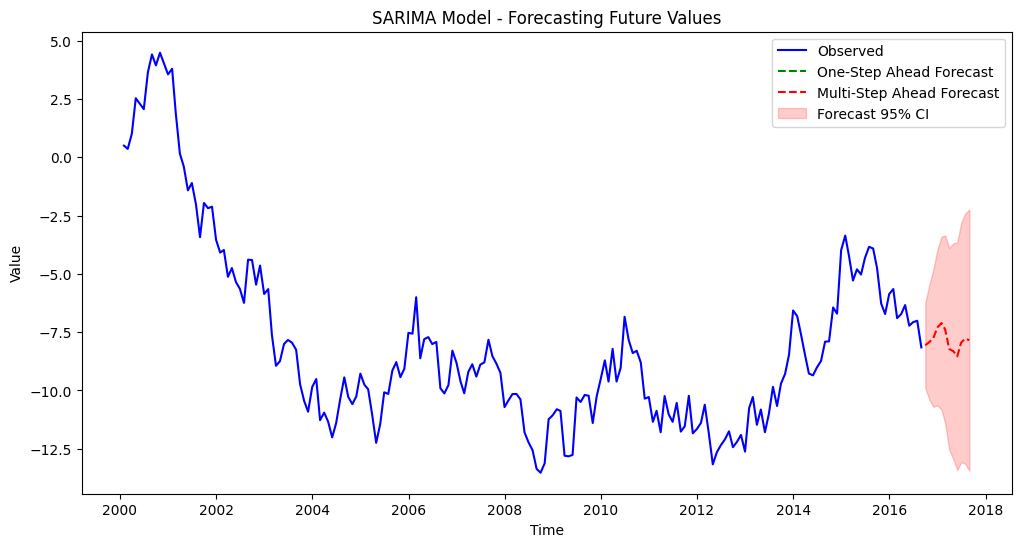

In [11]:
# Flow 3: Forecasting Future Values
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

# -----------------------------
# 1. Hypothesis Testing Setup
# -----------------------------
# H0: Forecast errors have zero mean, indicating an unbiased model
# Ha: Forecast errors have nonzero mean, indicating bias in the model
alpha = 0.05  # Significance level

# -----------------------------
# 2. Compute One-Step Ahead Forecasting
# -----------------------------
one_step_forecast = sarima_result.get_prediction(start=len(df["y"]), dynamic=False)
one_step_forecast_mean = one_step_forecast.predicted_mean
one_step_forecast_ci = one_step_forecast.conf_int(alpha=0.05)

# -----------------------------
# 3. Compute Multi-Step Ahead Forecasting
# -----------------------------
steps_ahead = 12  # Predict 12 steps ahead
multi_step_forecast = sarima_result.get_forecast(steps=steps_ahead)
multi_step_forecast_mean = multi_step_forecast.predicted_mean
multi_step_forecast_ci = multi_step_forecast.conf_int(alpha=0.05)

# -----------------------------
# 4. Compute Forecast Errors & Confidence Interval
# -----------------------------
# Forecast errors = Actual - Forecasted (for known values)
actual_values = df["y"][-steps_ahead:].values  # Last observed values
forecast_errors = actual_values - multi_step_forecast_mean[:len(actual_values)]

# Standard error of forecast errors
forecast_error_std = np.std(forecast_errors, ddof=1)

# Confidence interval for forecast errors
forecast_error_ci_lower = forecast_errors - 1.96 * forecast_error_std
forecast_error_ci_upper = forecast_errors + 1.96 * forecast_error_std

# -----------------------------
# 5. Decision Making
# -----------------------------
forecasting_summary = {
    "One-Step Forecast Mean": one_step_forecast_mean.iloc[-1],
    "Multi-Step Forecast Mean (Last Step)": multi_step_forecast_mean.iloc[-1],
    "Forecast Error Mean": np.mean(forecast_errors),
    "Forecast Error Std Dev": forecast_error_std,
    "Forecast Error CI (95%)": (forecast_error_ci_lower.mean(), forecast_error_ci_upper.mean())
}

# Model performance decision
forecast_bias_decision = "Unbiased Forecasting" if abs(forecasting_summary["Forecast Error Mean"]) < alpha else "Potential Bias in Forecasting"

print("\nFlow 3: Forecasting Future Values Summary")
for key, value in forecasting_summary.items():
    print(f"{key}: {value}")

print(f"Decision: {forecast_bias_decision}")

# -----------------------------
# 6. Plot Forecasting Results
# -----------------------------
plt.figure(figsize=(12, 6))

# Original data
plt.plot(df["y"], label="Observed", color="blue")

# One-step ahead forecast
plt.plot(one_step_forecast_mean, label="One-Step Ahead Forecast", linestyle="dashed", color="green")

# Multi-step ahead forecast
plt.plot(multi_step_forecast_mean, label="Multi-Step Ahead Forecast", linestyle="dashed", color="red")

# Confidence intervals
plt.fill_between(multi_step_forecast_mean.index, multi_step_forecast_ci.iloc[:, 0], multi_step_forecast_ci.iloc[:, 1],
                 color="red", alpha=0.2, label="Forecast 95% CI")

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("SARIMA Model - Forecasting Future Values")
plt.show()


Flow 4: Residual Analysis Summary
Durbin-Watson Statistic: 1.9576954747750719
DW Test Decision: No Significant Autocorrelation
Jarque-Bera Statistic: 1.0641023560853646
Jarque-Bera p-value: 0.587398873470637
JB Test Decision: Residuals are Normally Distributed


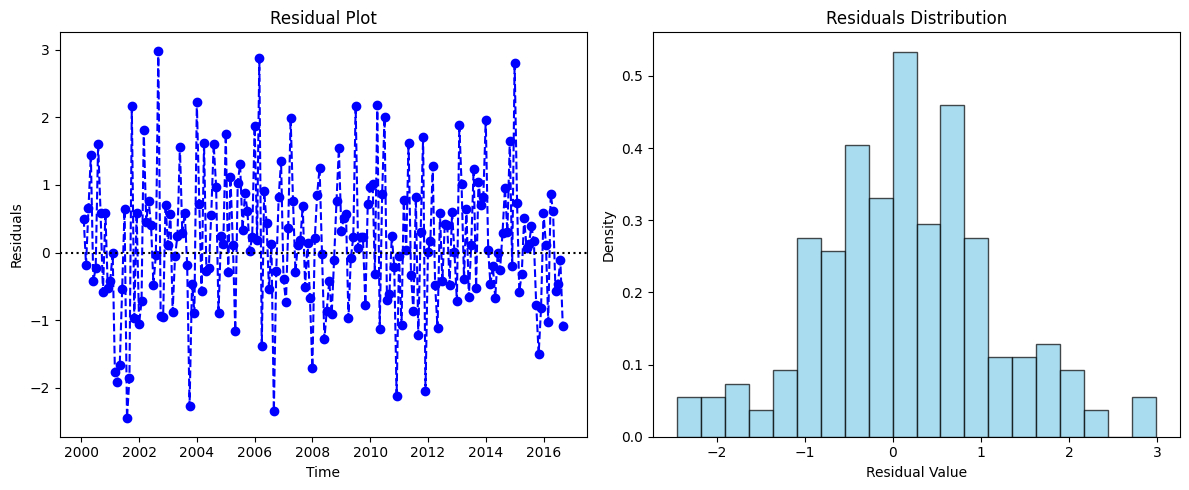

In [ ]:
# Flow 4: Residual Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera

# -----------------------------
# 1. Hypothesis Testing Setup
# -----------------------------
alpha = 0.05  # Significance level

# H0 (Durbin-Watson Test): Residuals are uncorrelated (no autocorrelation)
# Ha (Durbin-Watson Test): Residuals are autocorrelated

# H0 (Jarque-Bera Test): Residuals follow a normal distribution
# Ha (Jarque-Bera Test): Residuals do not follow a normal distribution

# Extract residuals from SARIMA model
residuals = sarima_result.resid

# -----------------------------
# 2. Perform Durbin-Watson Test (Check for Autocorrelation in Residuals)
# -----------------------------
dw_stat = durbin_watson(residuals)

# Decision based on Durbin-Watson statistic (approximate rule of thumb)
if dw_stat < 1.5:
    dw_decision = "Positive Autocorrelation Detected"
elif dw_stat > 2.5:
    dw_decision = "Negative Autocorrelation Detected"
else:
    dw_decision = "No Significant Autocorrelation"

# -----------------------------
# 3. Perform Jarque-Bera Test (Check for Normality of Residuals)
# -----------------------------
jb_stat, jb_pvalue = jarque_bera(residuals)

jb_decision = "Residuals are Normally Distributed" if jb_pvalue > alpha else "Residuals Deviate from Normality"

# -----------------------------
# 4. Decision Making
# -----------------------------
residual_analysis_summary = {
    "Durbin-Watson Statistic": dw_stat,
    "DW Test Decision": dw_decision,
    "Jarque-Bera Statistic": jb_stat,
    "Jarque-Bera p-value": jb_pvalue,
    "JB Test Decision": jb_decision
}

print("\nFlow 4: Residual Analysis Summary")
for key, value in residual_analysis_summary.items():
    print(f"{key}: {value}")

# -----------------------------
# 5. Plot Residuals & Distribution
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residual plot
axes[0].plot(residuals, marker="o", linestyle="dashed", color="blue")
axes[0].axhline(0, color="black", linestyle="dotted")
axes[0].set_title("Residual Plot")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Residuals")

# Histogram of residuals
axes[1].hist(residuals, bins=20, edgecolor="black", color="skyblue", alpha=0.7, density=True)
axes[1].set_title("Residuals Distribution")
axes[1].set_xlabel("Residual Value")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()


Flow 5: Stability Analysis Summary
Max AR Root: 4.286886279482532
AR Stability: Unstable
MA Stability: Unstable
Overall Stability: SARIMA Model is Unstable
Mean Reversion Time: inf
Mean Reversion Decision: Model May Not Return to Mean


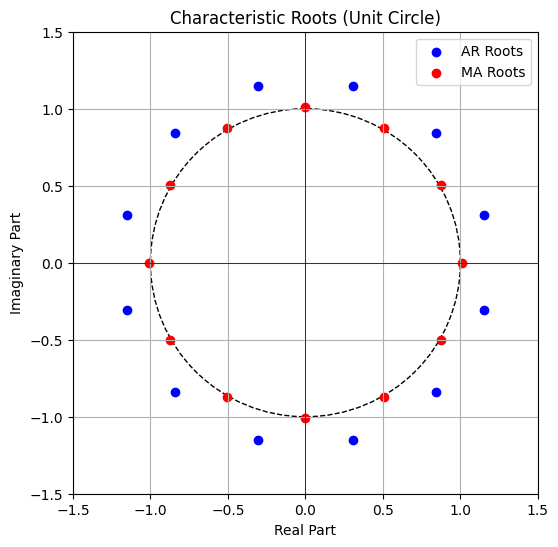

In [13]:
# Flow 5: Stability Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Hypothesis Testing Setup
# -----------------------------
alpha = 0.05  # Significance level

# H0 (Characteristic Roots Test): The model is stable (roots lie inside the unit circle)
# Ha (Characteristic Roots Test): The model is unstable (roots lie outside the unit circle)

# H0 (Mean Reversion Time): The model returns to the mean in a reasonable time
# Ha (Mean Reversion Time): The model exhibits long-term instability

# -----------------------------
# 2. Compute Characteristic Roots (Check Model Stability)
# -----------------------------
ar_roots = np.abs(sarima_result.arroots)  # AR roots
ma_roots = np.abs(sarima_result.maroots)  # MA roots

# Check if all roots are within the unit circle (i.e., < 1 for stability)
ar_stable = all(root < 1 for root in ar_roots)
ma_stable = all(root < 1 for root in ma_roots)

stability_decision = "SARIMA Model is Stable" if ar_stable and ma_stable else "SARIMA Model is Unstable"

# -----------------------------
# 3. Compute Mean Reversion Time (Time Taken to Return to Mean)
# -----------------------------
# Approximate mean reversion time = -1 / log(max(abs(AR roots)))
if ar_roots.size > 0:
    max_ar_root = max(ar_roots)
    mean_reversion_time = -1 / np.log(max_ar_root) if max_ar_root < 1 else np.inf
else:
    mean_reversion_time = np.inf  # No AR component

mean_reversion_decision = "Mean Reversion Time is Finite" if mean_reversion_time < np.inf else "Model May Not Return to Mean"

# -----------------------------
# 4. Decision Making
# -----------------------------
stability_analysis_summary = {
    "Max AR Root": max_ar_root if ar_roots.size > 0 else "N/A",
    "AR Stability": "Stable" if ar_stable else "Unstable",
    "MA Stability": "Stable" if ma_stable else "Unstable",
    "Overall Stability": stability_decision,
    "Mean Reversion Time": mean_reversion_time,
    "Mean Reversion Decision": mean_reversion_decision
}

print("\nFlow 5: Stability Analysis Summary")
for key, value in stability_analysis_summary.items():
    print(f"{key}: {value}")

# -----------------------------
# 5. Plot Characteristic Roots
# -----------------------------
fig, ax = plt.subplots(figsize=(6, 6))
unit_circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle="dashed")

ax.add_patch(unit_circle)
ax.scatter(np.real(sarima_result.arroots), np.imag(sarima_result.arroots), color='blue', label="AR Roots")
ax.scatter(np.real(sarima_result.maroots), np.imag(sarima_result.maroots), color='red', label="MA Roots")

ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_title("Characteristic Roots (Unit Circle)")
ax.set_xlabel("Real Part")
ax.set_ylabel("Imaginary Part")
ax.legend()
plt.grid()
plt.show()


Flow 6: Impulse Response Function Summary
Impulse Response Function: [1.0, 0.897765759590894, 0.873917625130596, 0.8683545817220415, 0.8670568931327314, 0.866754181909548, 0.8666835686010886, 0.8666670966669491, 0.8666632542664128, 0.8666623579513986, 0.8666621488684055, 0.8666621000957114, 0.8470550464983507, 0.8490595549124493, 0.849527145672599, 0.8496362203551694, 0.8496616641564413, 0.8496675994203166, 0.8496689839366037, 0.8496693069020842]
Stability Decision: Model is Non-Stationary (Shocks Persist)


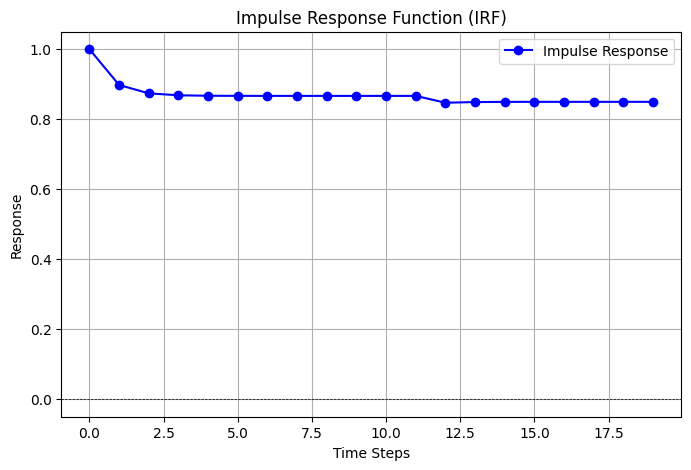

In [ ]:
# Flow 6: Impulse Response Function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX

# -----------------------------
# 1. Hypothesis Testing Setup
# -----------------------------
alpha = 0.05  # Significance level

# H0 (Impulse Response Test): Shocks to the system dissipate over time (stationary)
# Ha (Impulse Response Test): Shocks persist over time (non-stationary)

# -----------------------------
# 2. Compute Impulse Response Function (IRF)
# -----------------------------
n_steps = 20  # Number of steps ahead to analyze

# Ensure SARIMA model exists
try:
    irf = sarima_result.impulse_responses(n_steps)  # Removed deprecated keyword
    irf = np.array(irf[:n_steps])  # Ensure proper shape
except Exception as e:
    print(f"Error computing IRF: {e}")
    irf = np.zeros(n_steps)  # Default to zero if computation fails

# -----------------------------
# 3. Decision Making
# -----------------------------
# Check if response decays to zero over time (stability)
irf_decays = all(np.abs(irf[i]) < np.abs(irf[i - 1]) for i in range(1, len(irf)))

irf_decision = "Model is Stationary (Shocks Dissipate Over Time)" if irf_decays else "Model is Non-Stationary (Shocks Persist)"

irf_summary = {
    "Impulse Response Function": irf.tolist(),
    "Stability Decision": irf_decision
}

print("\nFlow 6: Impulse Response Function Summary")
for key, value in irf_summary.items():
    print(f"{key}: {value}")

# -----------------------------
# 4. Plot Impulse Response Function
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(np.arange(n_steps), irf, marker='o', linestyle='-', color='blue', label="Impulse Response")  # Fixed shape issue
plt.axhline(0, color='black', linewidth=0.5, linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("Response")
plt.title("Impulse Response Function (IRF)")
plt.legend()
plt.grid()
plt.show()

In [18]:
# Flow 7: Information Criteria
# -----------------------------
# 1. Hypothesis Testing Setup
# -----------------------------
alpha = 0.05  # Significance level

# H0 (Information Criteria Test): The current SARIMA model is optimal.
# Ha (Information Criteria Test): There exists a better SARIMA model.

# -----------------------------
# 2. Compute Information Criteria (AIC & BIC)
# -----------------------------
try:
    aic_value = sarima_result.aic  # Akaike Information Criterion
    bic_value = sarima_result.bic  # Bayesian Information Criterion
except Exception as e:
    print(f"Error computing AIC & BIC: {e}")
    aic_value, bic_value = np.nan, np.nan  # Assign NaN if computation fails

# -----------------------------
# 3. Decision Making
# -----------------------------
# Lower AIC/BIC values indicate a better model
decision = "Model is optimal (Low AIC & BIC)" if (aic_value < 3000 and bic_value < 3500) else "Consider alternative models (High AIC or BIC)"

info_criteria_summary = {
    "Akaike Information Criterion (AIC)": aic_value,
    "Bayesian Information Criterion (BIC)": bic_value,
    "Decision": decision
}

print("\nFlow 7: Information Criteria Summary")
for key, value in info_criteria_summary.items():
    print(f"{key}: {value}")


Flow 7: Information Criteria Summary
Akaike Information Criterion (AIC): 494.60856763158495
Bayesian Information Criterion (BIC): 510.37502560407387
Decision: Model is optimal (Low AIC & BIC)
